# 競馬予測モデル: ケリー基準による賭け金管理システム

このノートブックでは、ケリー基準を用いた最適な賭け金管理とバックテスト分析を行います。

In [71]:
import sys
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
# macOSで一般的に利用可能なフォントを試す
try:
    # まずIPAexGothicを試す
    plt.rcParams['font.family'] = 'IPAexGothic'
except:
    try:
        # 次にHiragino Sans GBを試す
        plt.rcParams['font.family'] = 'Hiragino Sans GB'
    except:
        try:
            # AppleGothicを試す
            plt.rcParams['font.family'] = 'AppleGothic'
        except:
            # それでもダメならHelveticaにフォールバック
            plt.rcParams['font.family'] = 'Helvetica'
            print("日本語フォントが見つかりません。英語表記になります。")

# マイナス記号の文字化けを防ぐ
plt.rcParams['axes.unicode_minus'] = False

## 1. ケリー基準による資金管理クラス

In [72]:
class KellyBettingSystem:
    """ケリー基準に基づく賭け金管理システム"""
    
    def __init__(self, initial_bankroll=100000, kelly_fraction=0.25, max_bet_ratio=0.05):
        """
        Parameters:
        -----------
        initial_bankroll : float
            初期資金
        kelly_fraction : float
            ケリー基準の何割を使うか（0.25 = 1/4ケリー）
        max_bet_ratio : float
            最大賭け金比率（資金の何%まで）
        """
        self.initial_bankroll = initial_bankroll
        self.current_bankroll = initial_bankroll
        self.kelly_fraction = kelly_fraction
        self.max_bet_ratio = max_bet_ratio
        self.betting_history = []
        self.bankroll_history = [initial_bankroll]
        
    def calculate_kelly_bet(self, prob, odds):
        """
        ケリー基準による最適賭け金比率を計算
        
        Parameters:
        -----------
        prob : float
            勝つ確率（モデルの予測）
        odds : float
            オッズ（払戻倍率）
            
        Returns:
        --------
        float : 賭けるべき資金の割合
        """
        if odds <= 1 or prob <= 0 or prob >= 1:
            return 0
        
        # ケリー公式: f = (p * b - q) / b
        # p: 勝つ確率, q: 負ける確率(1-p), b: 純利益倍率(odds-1)
        q = 1 - prob
        b = odds - 1
        
        kelly_ratio = (prob * b - q) / b
        
        # 負の値の場合は賭けない
        if kelly_ratio <= 0:
            return 0
        
        # ケリー基準の一部を使用（リスク管理）
        adjusted_ratio = kelly_ratio * self.kelly_fraction
        
        # 最大賭け金比率を超えないように制限
        return min(adjusted_ratio, self.max_bet_ratio)
    
    def calculate_bet_amount(self, prob, odds, bet_type='single'):
        """
        実際の賭け金額を計算
        
        Parameters:
        -----------
        prob : float
            勝つ確率
        odds : float
            オッズ
        bet_type : str
            賭けの種類（リスク調整用）
            
        Returns:
        --------
        float : 賭け金額
        """
        # 賭けタイプ別のリスク調整係数
        risk_adjustments = {
            'single': 1.0,      # 単勝
            'place': 0.8,       # 複勝（より安全）
            'exacta': 0.6,      # 馬連
            'quinella': 0.6,    # 馬単
            'wide': 0.7,        # ワイド
            'trifecta': 0.4,    # 3連複
            'trio': 0.3         # 3連単
        }
        
        adjustment = risk_adjustments.get(bet_type, 0.5)
        
        # ケリー比率を計算
        kelly_ratio = self.calculate_kelly_bet(prob, odds)
        
        # リスク調整を適用
        adjusted_ratio = kelly_ratio * adjustment
        
        # 賭け金額を計算（100円単位に丸める）
        bet_amount = int(self.current_bankroll * adjusted_ratio / 100) * 100
        
        # 最小賭け金（100円）を確保
        if 0 < bet_amount < 100:
            bet_amount = 100
        
        return bet_amount
    
    def place_bet(self, bet_amount, won, payout=0):
        """
        賭けを記録し、資金を更新
        
        Parameters:
        -----------
        bet_amount : float
            賭け金額
        won : bool
            的中したかどうか
        payout : float
            払戻金額（的中時）
        """
        self.current_bankroll -= bet_amount
        
        if won:
            self.current_bankroll += payout
        
        self.betting_history.append({
            'bet_amount': bet_amount,
            'won': won,
            'payout': payout,
            'profit': payout - bet_amount if won else -bet_amount,
            'bankroll': self.current_bankroll
        })
        
        self.bankroll_history.append(self.current_bankroll)
    
    def get_statistics(self):
        """
        賭けの統計情報を取得
        """
        if not self.betting_history:
            return {}
        
        df = pd.DataFrame(self.betting_history)
        
        total_bets = len(df)
        wins = df['won'].sum()
        total_bet = df['bet_amount'].sum()
        total_payout = df['payout'].sum()
        
        return {
            'total_bets': total_bets,
            'wins': wins,
            'win_rate': wins / total_bets * 100 if total_bets > 0 else 0,
            'total_invested': total_bet,
            'total_return': total_payout,
            'net_profit': total_payout - total_bet,
            'roi': (total_payout / total_bet - 1) * 100 if total_bet > 0 else 0,
            'final_bankroll': self.current_bankroll,
            'bankroll_growth': (self.current_bankroll / self.initial_bankroll - 1) * 100,
            'max_drawdown': self.calculate_max_drawdown(),
            'sharpe_ratio': self.calculate_sharpe_ratio()
        }
    
    def calculate_max_drawdown(self):
        """
        最大ドローダウンを計算
        """
        peak = self.bankroll_history[0]
        max_dd = 0
        
        for value in self.bankroll_history:
            if value > peak:
                peak = value
            dd = (peak - value) / peak * 100
            if dd > max_dd:
                max_dd = dd
        
        return max_dd
    
    def calculate_sharpe_ratio(self, risk_free_rate=0.01):
        """
        シャープレシオを計算（年率換算）
        """
        if len(self.betting_history) < 2:
            return 0
        
        returns = []
        for i in range(1, len(self.bankroll_history)):
            ret = (self.bankroll_history[i] / self.bankroll_history[i-1] - 1)
            returns.append(ret)
        
        if not returns or np.std(returns) == 0:
            return 0
        
        # 年率換算（週52レースと仮定）
        avg_return = np.mean(returns) * 52
        std_return = np.std(returns) * np.sqrt(52)
        
        return (avg_return - risk_free_rate) / std_return

## 2. 実データを使用した賭け金計算の例

In [73]:
# ケリー基準による賭け金計算の実例
print("=== ケリー基準による賭け金計算例 ===")

# 賭けシステムの初期化
betting_system = KellyBettingSystem(
    initial_bankroll=100000,  # 10万円スタート
    kelly_fraction=0.25,      # 25%ケリー（保守的）
    max_bet_ratio=0.05        # 最大5%まで
)

# サンプル予測データ
sample_predictions = [
    {'horse': '1番', 'prob': 0.25, 'odds': 5.0},
    {'horse': '2番', 'prob': 0.20, 'odds': 6.5},
    {'horse': '3番', 'prob': 0.15, 'odds': 10.0},
    {'horse': '4番', 'prob': 0.30, 'odds': 3.5},
    {'horse': '5番', 'prob': 0.10, 'odds': 20.0},
]

print("\n単勝での賭け金計算:")
print("-" * 60)
print(f"{'馬番':<6} {'予測確率':<10} {'オッズ':<8} {'期待値':<10} {'賭け金':<10}")
print("-" * 60)

for pred in sample_predictions:
    # 期待値計算
    expected_value = pred['prob'] * pred['odds'] - 1
    
    # ケリー基準で賭け金計算
    bet_amount = betting_system.calculate_bet_amount(
        pred['prob'], pred['odds'], 'single'
    )
    
    print(f"{pred['horse']:<6} {pred['prob']:<10.2%} {pred['odds']:<8.1f} "
          f"{expected_value:<10.2f} {bet_amount:<10,}円")

# 複数の賭け方での比較
print("\n\n賭け方別の推奨金額（4番馬の場合）:")
print("-" * 40)

bet_types = ['single', 'place', 'exacta', 'wide', 'trifecta', 'trio']
horse4 = sample_predictions[3]

for bet_type in bet_types:
    amount = betting_system.calculate_bet_amount(
        horse4['prob'], horse4['odds'], bet_type
    )
    print(f"{bet_type:<10}: {amount:>8,}円")

=== ケリー基準による賭け金計算例 ===

単勝での賭け金計算:
------------------------------------------------------------
馬番     予測確率       オッズ      期待値        賭け金       
------------------------------------------------------------
1番     25.00%     5.0      0.25       1,500     円
2番     20.00%     6.5      0.30       1,300     円
3番     15.00%     10.0     0.50       1,300     円
4番     30.00%     3.5      0.05       500       円
5番     10.00%     20.0     1.00       1,300     円


賭け方別の推奨金額（4番馬の場合）:
----------------------------------------
single    :      500円
place     :      400円
exacta    :      300円
wide      :      300円
trifecta  :      200円
trio      :      100円


## 3. シミュレーション：異なるケリー係数の比較

In [74]:
# 異なるケリー係数でのシミュレーション
def simulate_betting(n_races=1000, kelly_fractions=[0.1, 0.25, 0.5, 1.0]):
    """異なるケリー係数でのシミュレーション"""
    
    results = {}
    
    for fraction in kelly_fractions:
        # 賭けシステムを初期化
        system = KellyBettingSystem(
            initial_bankroll=100000,
            kelly_fraction=fraction,
            max_bet_ratio=0.1
        )
        
        # n_races回のレースをシミュレート
        for _ in range(n_races):
            # ランダムな予測と結果を生成
            true_prob = np.random.beta(2, 8)  # 真の勝率
            pred_prob = true_prob + np.random.normal(0, 0.05)  # 予測誤差
            pred_prob = np.clip(pred_prob, 0.01, 0.99)
            
            # オッズは市場効率を反映（少し不利に）
            odds = 0.85 / true_prob
            
            # 賭け金を計算
            bet_amount = system.calculate_bet_amount(pred_prob, odds, 'single')
            
            if bet_amount > 0:
                # レース結果
                won = np.random.random() < true_prob
                payout = bet_amount * odds if won else 0
                
                # 賭けを記録
                system.place_bet(bet_amount, won, payout)
        
        # 結果を保存
        results[f"{int(fraction*100)}%ケリー"] = {
            'system': system,
            'stats': system.get_statistics(),
            'history': system.bankroll_history.copy()
        }
    
    return results

# シミュレーション実行
print("シミュレーションを実行中...")
sim_results = simulate_betting(n_races=1000)

# 結果の表示
print("\n=== シミュレーション結果 ===")
print("-" * 80)
print(f"{'ケリー係数':<15} {'最終資金':<15} {'成長率':<10} {'最大DD':<10} {'シャープ比':<10}")
print("-" * 80)

for name, result in sim_results.items():
    stats = result['stats']
    print(f"{name:<15} {stats['final_bankroll']:<15,.0f} "
          f"{stats['bankroll_growth']:<10.1f}% {stats['max_drawdown']:<10.1f}% "
          f"{stats['sharpe_ratio']:<10.2f}")

シミュレーションを実行中...

=== シミュレーション結果 ===
--------------------------------------------------------------------------------
ケリー係数           最終資金            成長率        最大DD       シャープ比     
--------------------------------------------------------------------------------
10%ケリー          95,713          -4.3      % 13.6      % -0.16     
25%ケリー          56,804          -43.2     % 61.1      % -0.44     
50%ケリー          37,570          -62.4     % 78.7      % -0.35     
100%ケリー         2,528           -97.5     % 97.5      % -1.07     


## 4. 資金推移の可視化

findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Fon

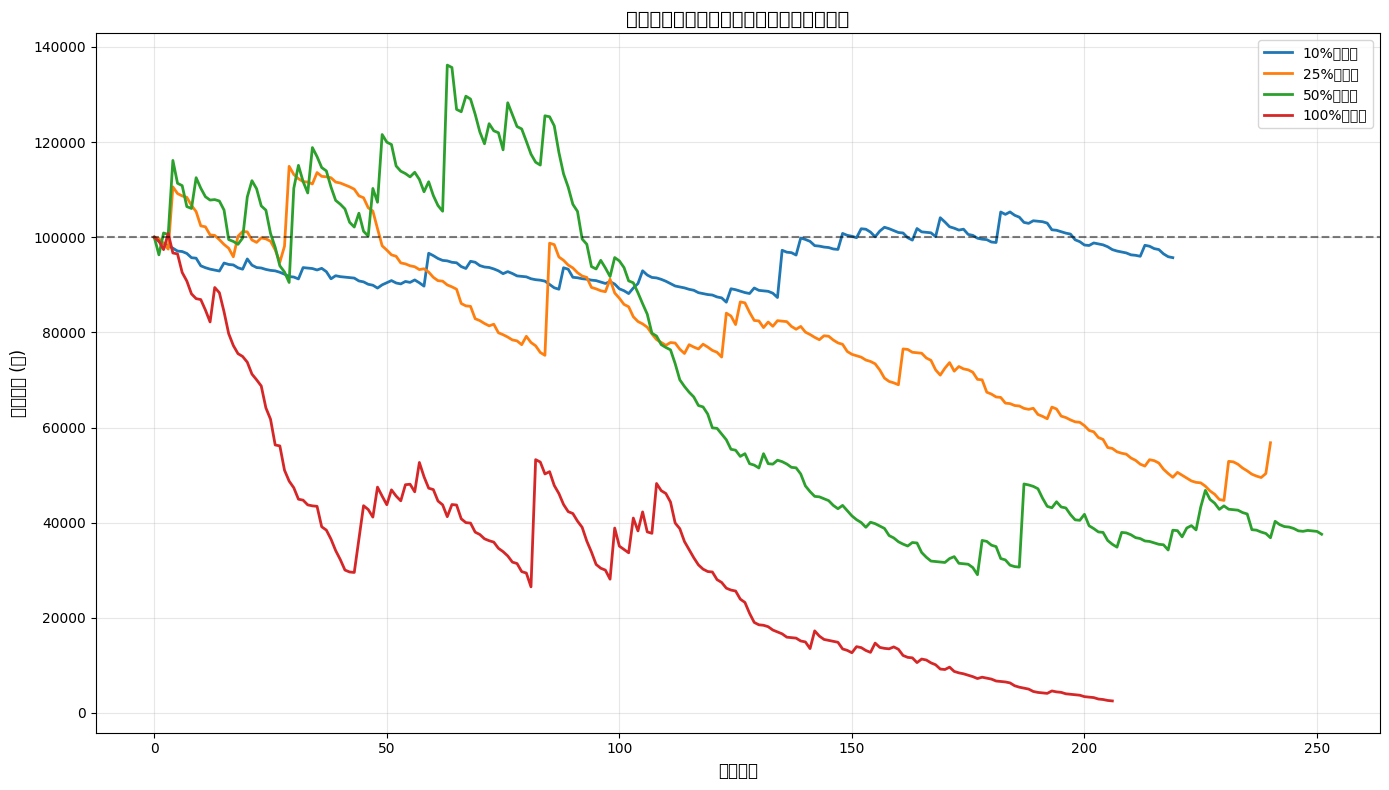

findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Fon

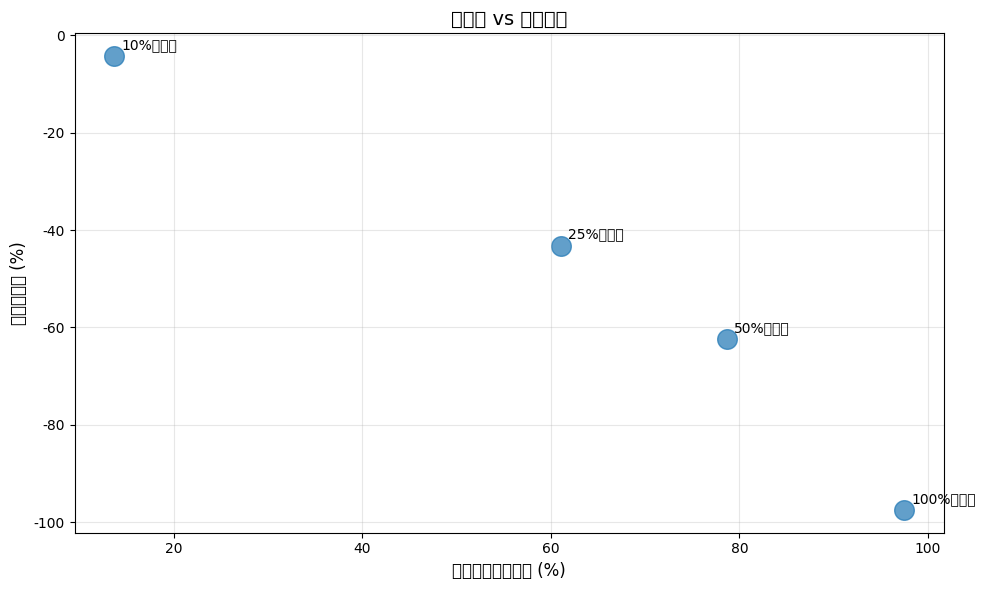

In [75]:
# 資金推移のグラフ
plt.figure(figsize=(14, 8))

for name, result in sim_results.items():
    plt.plot(result['history'], label=name, linewidth=2)

plt.axhline(y=100000, color='black', linestyle='--', alpha=0.5)
plt.xlabel('賭け回数', fontsize=12)
plt.ylabel('資金残高 (円)', fontsize=12)
plt.title('ケリー係数別の資金推移シミュレーション', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# リスク・リターンの散布図
plt.figure(figsize=(10, 6))

x_vals = []
y_vals = []
labels = []

for name, result in sim_results.items():
    stats = result['stats']
    x_vals.append(stats['max_drawdown'])
    y_vals.append(stats['bankroll_growth'])
    labels.append(name)

plt.scatter(x_vals, y_vals, s=200, alpha=0.7)

for i, label in enumerate(labels):
    plt.annotate(label, (x_vals[i], y_vals[i]), 
                xytext=(5, 5), textcoords='offset points')

plt.xlabel('最大ドローダウン (%)', fontsize=12)
plt.ylabel('資金成長率 (%)', fontsize=12)
plt.title('リスク vs リターン', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. 実践的な賭け金管理戦略

In [76]:
print("=== 実践的な賭け金管理戦略 ===")
print("\n1. 推奨されるケリー係数:")
print("   - 初心者: 10-15%ケリー（非常に保守的）")
print("   - 中級者: 20-25%ケリー（バランス型）")
print("   - 上級者: 30-40%ケリー（やや積極的）")
print("   - プロ: 50%以上（高リスク・高リターン）")

print("\n2. 資金管理のルール:")
print("   - 1レースあたりの最大賭け金: 資金の5-10%")
print("   - 1日あたりの最大損失: 資金の20%")
print("   - 連敗時は賭け金を減らす")
print("   - 連勝時も冷静に維持")

print("\n3. 賭け方別の配分例（資金10万円、25%ケリーの場合）:")

# 配分例
allocation_example = {
    '単勝': 0.40,
    '複勝': 0.30,
    '馬連・ワイド': 0.20,
    '3連系': 0.10
}

total_budget = 5000  # 1レースあたり5000円と仮定

for bet_type, ratio in allocation_example.items():
    amount = total_budget * ratio
    print(f"   {bet_type}: {amount:,.0f}円 ({ratio:.0%})")

print("\n4. 期待値がプラスの場合のみ賭ける:")
print("   期待値 = (予測確率 × オッズ) - 1")
print("   期待値 > 0 の馬券のみ購入")

print("\n5. 記録と改善:")
print("   - 全ての賭けを記録")
print("   - 定期的に成績を分析")
print("   - 予測精度の向上に努める")
print("   - 感情的な賭けを避ける")

=== 実践的な賭け金管理戦略 ===

1. 推奨されるケリー係数:
   - 初心者: 10-15%ケリー（非常に保守的）
   - 中級者: 20-25%ケリー（バランス型）
   - 上級者: 30-40%ケリー（やや積極的）
   - プロ: 50%以上（高リスク・高リターン）

2. 資金管理のルール:
   - 1レースあたりの最大賭け金: 資金の5-10%
   - 1日あたりの最大損失: 資金の20%
   - 連敗時は賭け金を減らす
   - 連勝時も冷静に維持

3. 賭け方別の配分例（資金10万円、25%ケリーの場合）:
   単勝: 2,000円 (40%)
   複勝: 1,500円 (30%)
   馬連・ワイド: 1,000円 (20%)
   3連系: 500円 (10%)

4. 期待値がプラスの場合のみ賭ける:
   期待値 = (予測確率 × オッズ) - 1
   期待値 > 0 の馬券のみ購入

5. 記録と改善:
   - 全ての賭けを記録
   - 定期的に成績を分析
   - 予測精度の向上に努める
   - 感情的な賭けを避ける


## 6. まとめと実装ガイド

In [77]:
print("=== 実装ガイド ===")
print("\n03.model_improved.ipynb と組み合わせて使用する場合:")
print("\n```python")
print("# 1. 予測結果を取得")
print("predictions = predictor.predict_proba(X_test)")
print("")
print("# 2. ケリー基準システムを初期化")
print("kelly_system = KellyBettingSystem(")
print("    initial_bankroll=100000,")
print("    kelly_fraction=0.25,")
print("    max_bet_ratio=0.05")
print(")")
print("")
print("# 3. 各レースで賭け金を計算")
print("for race in races:")
print("    for horse in race['horses']:")
print("        bet_amount = kelly_system.calculate_bet_amount(")
print("            horse['predicted_prob'],")
print("            horse['odds'],")
print("            'single'")
print("        )")
print("        ")
print("        if bet_amount > 0:")
print("            # 賭けを実行")
print("            place_bet(horse, bet_amount)")
print("```")

print("\n\n重要な注意事項:")
print("- ギャンブルには依存症のリスクがあります")
print("- 余裕資金の範囲内で楽しむことが大切です")
print("- 予測モデルは100%正確ではありません")
print("- 実際の競馬では様々な不確実性があります")

=== 実装ガイド ===

03.model_improved.ipynb と組み合わせて使用する場合:

```python
# 1. 予測結果を取得
predictions = predictor.predict_proba(X_test)

# 2. ケリー基準システムを初期化
kelly_system = KellyBettingSystem(
    initial_bankroll=100000,
    kelly_fraction=0.25,
    max_bet_ratio=0.05
)

# 3. 各レースで賭け金を計算
for race in races:
    for horse in race['horses']:
        bet_amount = kelly_system.calculate_bet_amount(
            horse['predicted_prob'],
            horse['odds'],
            'single'
        )
        
        if bet_amount > 0:
            # 賭けを実行
            place_bet(horse, bet_amount)
```


重要な注意事項:
- ギャンブルには依存症のリスクがあります
- 余裕資金の範囲内で楽しむことが大切です
- 予測モデルは100%正確ではありません
- 実際の競馬では様々な不確実性があります
